In [24]:
import networkx as nx
import numpy as np
import pandas as pd #Import our packages to use throughout the code
import matplotlib.pyplot as plt
import seaborn as sns

bikeGraphOverall = nx.DiGraph()
df = pd.read_csv("LondonBikeJourneyAug2023.csv") #Reading the graph in from PDF into pandas dataframe
ride_counts = df.groupby(['Start station', 'End station']).size().reset_index(name='ride_count')
for _, row in ride_counts.iterrows(): #Want to count ride_count so that we can weight our edges later on. 
        bikeGraphOverall.add_edge(row['Start station'], row['End station'], weight=row['ride_count'])

In [25]:
#Specific method allows us to quickly draw the graph, giving us the top 30 nodes
def visualize_graph(G, top_n=30):
    station_degrees = dict(G.degree())
    top_stations = sorted(station_degrees, key=station_degrees.get, reverse=True)[:top_n]#Takes the top 30 sorted by degree (key in the dict)
    
    subgraph = G.subgraph(top_stations)
    
    plt.figure(figsize=(12, 8)) #Plots our figure
    pos = nx.spring_layout(subgraph, k=0.5, iterations=50)
    
    nx.draw_networkx_nodes(subgraph, pos, node_color='lightblue', node_size=[station_degrees[node] for node in subgraph.nodes()]) #This draws the nodes
    
    edges = subgraph.edges()
    weights = [G[u][v]['weight'] for u,v in edges]
    nx.draw_networkx_edges(subgraph, pos, width=[w / 1000 for w in weights], edge_color='black', arrows=True) #This is where we add the weights from above, where weight corresponds to ride_count
    
    nx.draw_networkx_labels(subgraph, pos, font_size=8) #Draws Labels on our nodes for stations
    
    plt.title('Top 30 Bike Stations')
    plt.axis('off')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [26]:
print(f"Total number of stations: {len(bikeGraphOverall.nodes())}") #Prints Total Number of Stations (Nodes) and Routes (Edges)
print(f"Total number of routes: {len(bikeGraphOverall.edges())}")
#Here we wanted to obtain some sample statistics
route_frequencies = [(u, v, d['weight']) for (u, v, d) in bikeGraphOverall.edges(data=True)]
top_routes = sorted(route_frequencies, key=lambda x: x[2], reverse=True)[:10]
print("\nTop 10 Most Frequent Routes:")
for start, end, count in top_routes:
    print(f"{start} to {end}: {count} rides")
print("Average Node Degree")
print(sum(dict(bikeGraphOverall.degree()).values()) / bikeGraphOverall.number_of_nodes()) #Average Degree of nodes
print("Graph Density")
print(nx.density(bikeGraphOverall)) #Gets the density of the graph
print("Graph Average Clustering Coefficient")
print(nx.average_clustering(bikeGraphOverall)) #Average clustering coefficient
degree_centrality = nx.degree_centrality(bikeGraphOverall) #Gets degree Centrality
betweenness_centrality = nx.betweenness_centrality(bikeGraphOverall) #Gets betweenness centrality
print("Max and Min Degree Centrality")
print(max(degree_centrality.values())) #Max and Min
print(min(degree_centrality.values())) 
print("Max and Min Betweenness Centrality")
print(max(betweenness_centrality.values())) #Max and Min
print(min(betweenness_centrality.values()))

Total number of stations: 802
Total number of routes: 191630

Top 10 Most Frequent Routes:
Hyde Park Corner, Hyde Park to Hyde Park Corner, Hyde Park: 2966 rides
Podium, Queen Elizabeth Olympic Park to Podium, Queen Elizabeth Olympic Park: 1813 rides
Triangle Car Park, Hyde Park to Triangle Car Park, Hyde Park: 1391 rides
Black Lion Gate, Kensington Gardens to Black Lion Gate, Kensington Gardens: 1343 rides
Albert Gate, Hyde Park to Albert Gate, Hyde Park: 1227 rides
Park Lane , Hyde Park to Park Lane , Hyde Park: 998 rides
Palace Gate, Kensington Gardens to Palace Gate, Kensington Gardens: 571 rides
Queen's Gate, Kensington Gardens to Queen's Gate, Kensington Gardens: 520 rides
Timber Lodge, Queen Elizabeth Olympic Park to Timber Lodge, Queen Elizabeth Olympic Park: 488 rides
Hyde Park Corner, Hyde Park to Albert Gate, Hyde Park: 464 rides
Average Node Degree
477.8802992518703
Graph Density
0.2983023091459865
Graph Average Clustering Coefficient
0.49274103061986013
Max and Min Degree 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


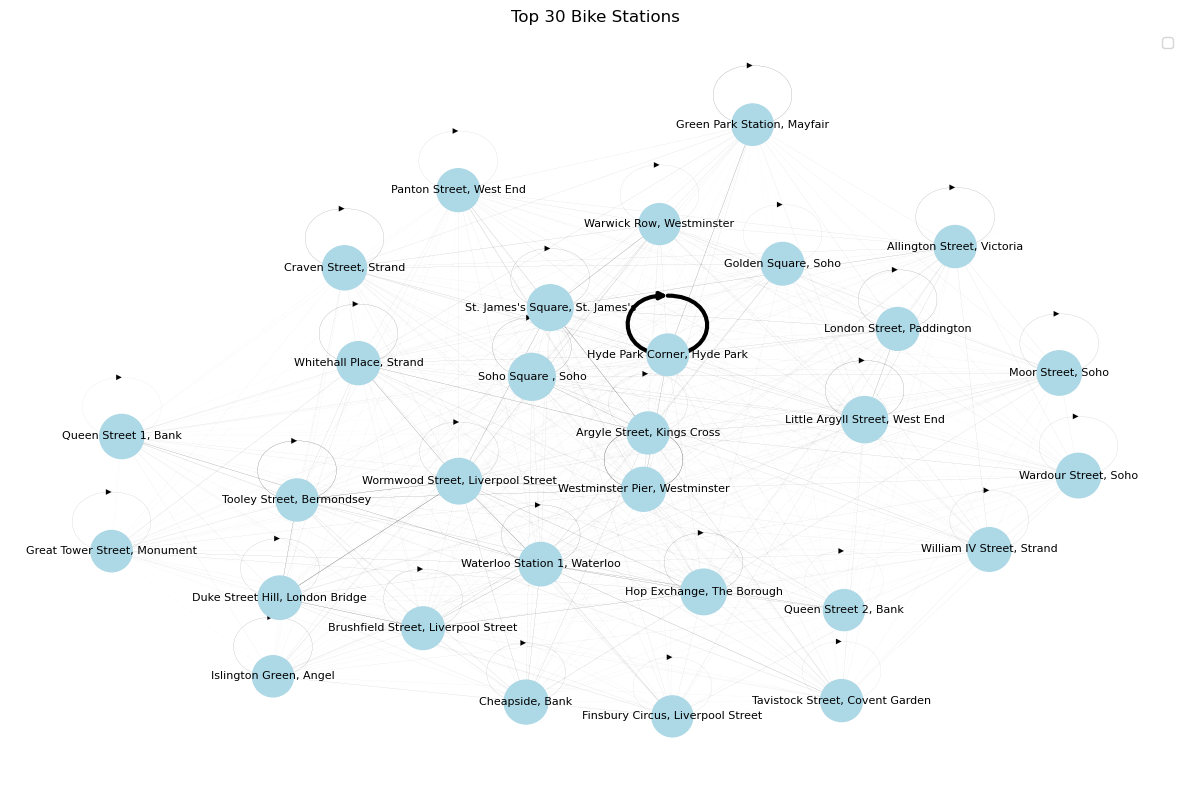

In [27]:
visualize_graph(bikeGraphOverall)
#Lets us visualise our graph

In [49]:
#This splits up our time period into the different time series we wanted. 
def getTime(hour):
    hour = int(hour)
    if 5 <= hour < 9:
        return 'Early Morning'
    elif 9 <= hour < 12:
        return 'Morning Peak'
    elif 12 <= hour < 15:
        return 'Midday' 
    elif 15 <= hour < 18:
        return 'Afternoon Peak'
    elif 18 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

In [50]:
def createGraph(df, time_segment=None, weekend_flag=None):
    df['datetime'] = pd.to_datetime(df['Start date'], format='%m/%d/%Y %H:%M')
    df['hour'] = df['datetime'].dt.hour
    df['weekend'] = df['datetime'].dt.day_name().isin(['Saturday', 'Sunday'])
    df['time_segment'] = df['hour'].apply(getTime)
    #Recreates our graph so that we can split by the time segement. 
    G = nx.DiGraph()
    ride_counts = filtered_df.groupby(['Start station', 'End station']).agg('Bike number': 'count','Total duration': ['mean', 'sum']})
    #https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.agg.html Wanted to group by combined instead of all at once. 
    ride_counts.columns = ['Start station', 'End station', 'ride_count', 'avg_duration', 'total_duration']
    #Redefined my columns
    for _, row in ride_counts.iterrows():
        G.add_edge(row['Start station'], row['End station'], weight=row['ride_count'])
    return G

In [ ]:
def calculate_network_efficiency(G):
    #Calculates the efficiency of the network by comparing taking all pairs shortest paths and then adding reciprocal
    n = len(G.nodes())
    totalpathlength = 0
    for node1 in G.nodes():
        for node2 in G.nodes():
            if node1 != node2: #Makes sure not to compare two nodes. 
                    pathLength = nx.shortest_path_length(G, node1, node2)
                    totalpathlength += 1 / pathLength
    return totalpathlength / (n * (n - 1)) #Makes it such that a fully connected graph is 1.0 and a fully disconnected is 0.0

In [ ]:
def comprehensive_network_resilience(G):
    resilience_metrics = {
        'total_stations': len(G.nodes()),'total_routes': len(G.edges()),'in_degree_stats': {'mean': np.mean([d for n, d in G.in_degree()]),'median': np.median([d for n, d in G.in_degree()]),'max': max([d for n, d in G.in_degree()]),},'out_degree_stats': {'mean': np.mean([d for n, d in G.out_degree()]),'median': np.median([d for n, d in G.out_degree()]),'max': max([d for n, d in G.out_degree()])}  
    }
    resilience_metrics['connected_components'] = nx.number_connected_components(G.to_undirected()) #Gives more network statistics for when we calculate removals
    resilience_metrics['largest_component_size'] = len(max(nx.connected_components(G.to_undirected()), key=len))
    resilience_metrics['network_diameter'] = nx.diameter(G.to_undirected())
    resilience_metrics['average_path_length'] = nx.average_shortest_path_length(G.to_undirected())
    resilience_metrics['clustering_coefficient'] = nx.average_clustering(G)
    resilience_metrics['network_density'] = nx.density(G) #Network statistics
    resilience_metrics['network_efficiency'] = calculate_network_efficiency(G)
    return resilience_metrics

In [ ]:
def simulate_advanced_station_removal(G, removal_percentage=20):
    all_stations = list(G.nodes())
    removal_count = int(len(all_stations) * (removal_percentage / 100))
    removal_strategies = {
        'Random Removal': np.random.choice(all_stations, removal_count, replace=False),
        'High Centrality Removal': [station for station, _ in sorted(nx.degree_centrality(G).items(), key=lambda x: x[1], reverse=True)[:removal_count]],
        #https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.degree_centrality.html#networkx.algorithms.centrality.degree_centrality
        'Betweenness Centrality Removal': [station for station, _ in sorted(nx.betweenness_centrality(G).items(), key=lambda x: x[1], reverse=True)[:removal_count]],
        #https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.betweenness_centrality.html
        'Low Degree Removal': [station for station, _ in sorted(G.degree(), key=lambda x: x[1])[:removal_count]]
    }
    removal_results = {}
    for strategy_name, stations_to_remove in removal_strategies.items():
        # Create a copy of the graph
        G_modified = G.copy()
        G_modified.remove_nodes_from(stations_to_remove)
        # Calculate resilience metrics
        removal_results[strategy_name] = {'removed_stations': stations_to_remove,'remaining_stations': len(G_modified.nodes()),'remaining_routes': len(G_modified.edges()),'connectivity_reduction': 1 - (len(G_modified.edges()) / len(G.edges())),'network_efficiency_reduction': (calculate_network_efficiency(G_modified) / calculate_network_efficiency(G))
        }
    return removal_results

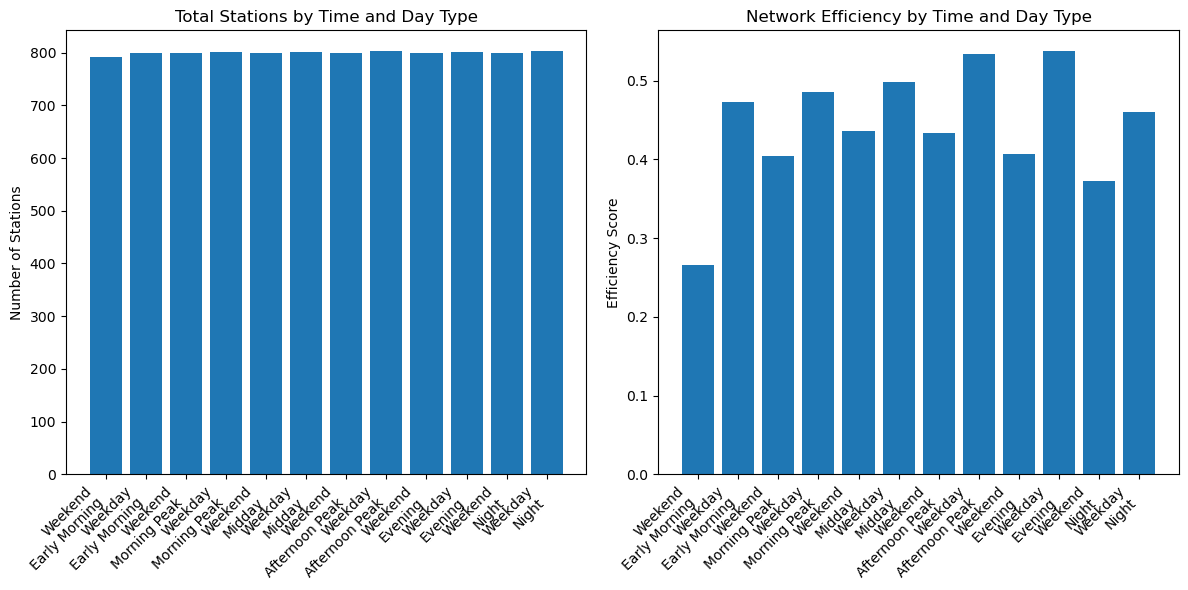

In [38]:
df = pd.read_csv('LondonBikeJourneyAug2023.csv')
# Give us our time segements
time_segments = ['Early Morning', 'Morning Peak', 'Midday', 'Afternoon Peak', 'Evening', 'Night']
day_types = [True, False] #Weekday and Weekend
# Store analysis results
results = {}
for time_segment in time_segments:
    for is_weekend in day_types:
        day_type = 'Weekend' if is_weekend else 'Weekday'
            key = f"{day_type} - {time_segment}" #Prints according to key
            results[key] = {'resilience_metrics': comprehensive_network_resilience(G),'removal_impact': simulate_advanced_station_removal(G)}
results

In [39]:
results

{'Weekend - Early Morning': {'resilience_metrics': {'total_stations': 792,
   'total_routes': 5864,
   'in_degree_stats': {'mean': 7.404040404040404, 'median': 6.0, 'max': 47},
   'out_degree_stats': {'mean': 7.404040404040404, 'median': 7.0, 'max': 31},
   'connected_components': 1,
   'largest_component_size': 792,
   'network_diameter': 6,
   'average_path_length': 2.949590723927007,
   'clustering_coefficient': 0.03811584939352471,
   'network_density': 0.009360354493097855,
   'network_efficiency': 0.26609569016100126},
  'removal_impact': {'Random Removal': {'removed_stations': array(['Sloane Avenue, Knightsbridge', 'Ormonde Gate, Chelsea',
           'Rodney Road , Walworth', 'Cotton Garden Estate, Kennington',
           'Empire Square, The Borough', 'Derry Street, Kensington',
           'Gower Place , Euston', 'Red Lion Square, Holborn',
           'Alma Road, Wandsworth', 'North Audley Street, Mayfair',
           'Harris Academy, Bermondsey', 'Harford Street, Mile End',
   